# Loan Application MLP model

We saw earlier that a single hidden layer MLP model was over-fitting the data.

Let us use different over-fitting techniques to address this issue.

## Data Preparation and Pre-processing

In [10]:
import pandas as pd

In [11]:
train_ds = pd.read_excel("Loan_Application.xlsx")

train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1570 non-null   int64  
 1   Decision      1570 non-null   int64  
 2   Selfcon_Code  1570 non-null   int64  
 3   Tier_1        1570 non-null   int64  
 4   Tier_2        1570 non-null   int64  
 5   AccoClass     1570 non-null   int64  
 6   LoanType      1570 non-null   int64  
 7   Gender        1570 non-null   int64  
 8   Etype         1570 non-null   int64  
 9   Doc_pf        1570 non-null   int64  
 10  Marstat       1570 non-null   int64  
 11  Emp_Type_1    1570 non-null   int64  
 12  Emp_Type_2    1570 non-null   int64  
 13  Emp_Type_3    1570 non-null   int64  
 14  Educlass_2    1570 non-null   int64  
 15  Educlass_1    1570 non-null   int64  
 16  Oriclass_1    1570 non-null   int64  
 17  Oriclass_2    1570 non-null   int64  
 18  eom_25        1570 non-null 

In [12]:
train_ds.columns

Index(['ID', 'Decision', 'Selfcon_Code', 'Tier_1', 'Tier_2', 'AccoClass',
       'LoanType', 'Gender', 'Etype', 'Doc_pf', 'Marstat', 'Emp_Type_1',
       'Emp_Type_2', 'Emp_Type_3', 'Educlass_2', 'Educlass_1', 'Oriclass_1',
       'Oriclass_2', 'eom_25', 'OldEmi_d', 'BankSave_d', 'Age', 'YrsAdd',
       'YrsJob', 'DispInc', 'MarVal', 'OldEmi', 'LoanReq', 'Term', 'Dwnpay',
       'BankSave', 'CalcEmi', 'IIR', 'IAR', 'FOIR', 'LTV', 'LVR',
       'dwnp_prop_p'],
      dtype='object')

In [13]:
# Setting up Independent and Dependent Variable

X = train_ds.iloc[:, 2:]
y = train_ds.iloc[:, 1]

In [14]:
num_inputs = X.shape[1]

In [15]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0)


In [16]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

## Model Building - Grid Search using Scikit-learn

In the previous session, we directly entered the hyper-parameter values without fiddling with it. Generally, we would have to fiddle with multiple values manually to finally decide a good combination of hyper-parameter values. But, this is quite a laborious and time-consuming task and hence most of the time impractical.

Instead, we could use Scikit-Learn's Grid Search. We just have to mention the various values of the hyper-parameters we would want to explore and Grid Search would evaluate all possible combinations of the values using cross-validation.

First, let us build the model architecture and define the various hyper-parameters we would be using.

In [17]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2,l1

# Function to build a Keras Model
def build_classifier(hidden_layers = [50], dropout_rate = 0.3,
                     regularization_type = l1, regularization_factor = 0.1, 
                     optimizer = 'adam', num_inputs = 36):
 
  model = Sequential()   # Initialize the Sequential API
  for layers in hidden_layers:   
    model.add(Dense(units = layers, input_dim = num_inputs, activation="relu", 
                    kernel_regularizer = regularization_type(regularization_factor)))
    model.add(BatchNormalization())
    model.add(Dropout(rate = dropout_rate))

  model.add(Dense(activation="sigmoid", units=1))
  
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

In [19]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

classifier = KerasClassifier(
    build_fn = build_classifier, num_inputs = num_inputs, batch_size = 100)

Now, that we have defined the model architecture, let us create a dictionary of hyper-parameters and various values we would want to pass for evaluation. 

The parameters dictionary indicates that Grid Search has 2 ^ 4 = 16 combinations of regularization_type, regularization_factor, dropout_rate and optimizer to explore and find for the best combination.

In [29]:
parameters = {'model__regularization_type' : [l1, l2],
              'model__regularization_factor' : [0.01, 0.1],
              'model__dropout_rate' : [0.3, 0.5],          
              'model__optimizer': ['adam', 'sgd']}

Let us import GridSearchCV and pass the estimator, parameter dictionary, scoring metric for evaluation and number of cross validation folds.

Since we have set the CV parameter to 10, we would be performing around 16 * 10 = 160 rounds of training per epoch. This means that is quite time consuming, and if we add additional parameter or value in the dictionary and increase the epochs, the rounds increase quite a lot of times. 

Hence GridSearchCV is preferable only when we have just few combinations and when the hyper-parameter search space is large, we tend to use RansomizedSearchCV. The difference being that instead of searching all the combinations, it evaluates a given number of random combinations by selecting random value for each hyperparmeter at every iteration.

Besides that, it is advisable to spare a thought on choosing the hyper-parameter based on the understanding of the concepts. For instance, when we observed the over-fitting earlier, we saw that it occurred quite early i.e. after first few epochs itself. We also know that one of the reasons for over-fitting, could be that the model is too complex for the dataset or has many variables than required. So, we can either do feature selection, which is quite difficult to do or use regularization technique such as l1 regularization, which can reduce the weights to zero and perform feature selection implicitly.

So, let us validate our understanding by passing on both l1 and l2 and see whether the grid search gives the best parameter as l1 or not.



In [30]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [31]:
grid_search = grid_search.fit(X_train, y_train, epochs=10)

/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2025-08-09 20:56:48.088956: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-09 20:56:48.089829: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-09 20:56:48.090599: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1754753208.091235 1548296 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1754753208.092571 1548296 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical Plugg

Epoch 1/10


2025-08-09 20:56:49.506158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5050 - loss: 3.1763
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5607 - loss: 2.9350
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5549 - loss: 2.7498
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6305 - loss: 2.5102
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6232 - loss: 2.4030
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6854 - loss: 2.1984
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7169 - loss: 2.0418
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7208 - loss: 1.8914
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7249 - loss: 1.7514
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7631 - loss: 1.6242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5138 - loss: 3.2280
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5338 - loss: 2.9972
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5738 - loss: 2.7829
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6256 - loss: 2.5364
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6570 - loss: 2.3604
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6871 - loss: 2.1940
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7079 - loss: 2.0630
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7431 - loss: 1.8757
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7603 - loss: 1.7705
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7587 - loss: 1.6265
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5259 - loss: 3.3709
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5656 - loss: 3.1041
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6104 - loss: 2.8242
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6382 - loss: 2.6469
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6679 - loss: 2.4518
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7107 - loss: 2.2529
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6996 - loss: 2.1193
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7532 - loss: 1.9479
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7412 - loss: 1.8328
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7710 - loss: 1.6796
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data

/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4911 - loss: 3.3541
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5517 - loss: 3.0549
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5813 - loss: 2.8209
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6491 - loss: 2.6055
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6472 - loss: 2.4619
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6913 - loss: 2.2691
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7018 - loss: 2.1393
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7197 - loss: 1.9629
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7645 - loss: 1.8289
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7552 - loss: 1.7084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4789 - loss: 3.3282
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5341 - loss: 3.0501
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5765 - loss: 2.8008
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6357 - loss: 2.6220
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6572 - loss: 2.4326
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6925 - loss: 2.2687
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7157 - loss: 2.1009
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6889 - loss: 1.9842
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7398 - loss: 1.8286
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7406 - loss: 1.7151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5169 - loss: 3.1505
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5306 - loss: 2.9240
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5976 - loss: 2.6947
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6241 - loss: 2.5300
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6688 - loss: 2.3117
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6939 - loss: 2.1620
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7043 - loss: 2.0235
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7271 - loss: 1.8511
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7543 - loss: 1.7048
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7648 - loss: 1.5845
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4683 - loss: 3.2617
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5067 - loss: 3.0330
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5725 - loss: 2.7873
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5950 - loss: 2.5913
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6361 - loss: 2.4129
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7131 - loss: 2.1970
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7048 - loss: 2.0815
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7269 - loss: 1.9269
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7189 - loss: 1.8042
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7984 - loss: 1.6170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4689 - loss: 3.3075
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5508 - loss: 3.0262
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5607 - loss: 2.8440
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6289 - loss: 2.5984
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6348 - loss: 2.4592
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6597 - loss: 2.2751
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7039 - loss: 2.1061
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7183 - loss: 1.9580
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7297 - loss: 1.8242
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7455 - loss: 1.6871
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5200 - loss: 3.2303
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5347 - loss: 2.9769
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6009 - loss: 2.7313
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6591 - loss: 2.5131
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6549 - loss: 2.3545
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6924 - loss: 2.1951
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6955 - loss: 2.0603
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7282 - loss: 1.9291
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7269 - loss: 1.8033
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7513 - loss: 1.6740
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4923 - loss: 3.2287
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4933 - loss: 3.0056
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5751 - loss: 2.7386
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6540 - loss: 2.5361
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6764 - loss: 2.3641
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7020 - loss: 2.2035
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7295 - loss: 2.0463
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7431 - loss: 1.9087
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7312 - loss: 1.7964
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7582 - loss: 1.6529
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4719 - loss: 1.4700
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5190 - loss: 1.2955
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5477 - loss: 1.1370
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6118 - loss: 1.0110
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6855 - loss: 0.9275
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7194 - loss: 0.9008
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7113 - loss: 0.8481
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7452 - loss: 0.8047
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7457 - loss: 0.7743
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7614 - loss: 0.7482
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4871 - loss: 1.4485
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5314 - loss: 1.2913
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5677 - loss: 1.1110
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5867 - loss: 1.0496
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6772 - loss: 0.9354
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6829 - loss: 0.8994
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7267 - loss: 0.8445
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7442 - loss: 0.8242
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7408 - loss: 0.7762
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7611 - loss: 0.7379
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5089 - loss: 1.3454
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5625 - loss: 1.1977
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6253 - loss: 1.0301
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6476 - loss: 0.9776
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6940 - loss: 0.9082
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6951 - loss: 0.8869
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7371 - loss: 0.8104
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7446 - loss: 0.7755
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7592 - loss: 0.7500
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7296 - loss: 0.7466
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4352 - loss: 1.4676
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4879 - loss: 1.2416
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5483 - loss: 1.0839
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6066 - loss: 1.0037
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6908 - loss: 0.9350
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6926 - loss: 0.9067
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7396 - loss: 0.8432
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7432 - loss: 0.7926
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7535 - loss: 0.7773
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7892 - loss: 0.7211
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4876 - loss: 1.4230
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5841 - loss: 1.1659
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5734 - loss: 1.1209
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6108 - loss: 1.0482
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6618 - loss: 0.9661
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6786 - loss: 0.9129
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7142 - loss: 0.8603
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7063 - loss: 0.8183
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7789
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7616 - loss: 0.7413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5126 - loss: 1.4644
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5354 - loss: 1.2784
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5910 - loss: 1.1102
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6184 - loss: 1.0241
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6691 - loss: 0.9383
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7109 - loss: 0.8745
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7394 - loss: 0.8224
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7428 - loss: 0.7965
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7713 - loss: 0.7426
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7591 - loss: 0.7304
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5235 - loss: 1.2885
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5919 - loss: 1.1443
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5947 - loss: 1.0993
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6122 - loss: 1.0046
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6572 - loss: 0.9668
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7130 - loss: 0.8722
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7384 - loss: 0.8264
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7257 - loss: 0.8004
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7384 - loss: 0.7719
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7856 - loss: 0.7068
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4953 - loss: 1.3281
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5671 - loss: 1.1578
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5832 - loss: 1.0856
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6575 - loss: 0.9929
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6640 - loss: 0.9505
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6908 - loss: 0.9081
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7509 - loss: 0.8103
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7501 - loss: 0.7932
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7552 - loss: 0.7656
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7582 - loss: 0.7476
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5476 - loss: 1.2115
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6138 - loss: 1.1126
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6099 - loss: 1.0512
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6596 - loss: 0.9632
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6742 - loss: 0.9280
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7036 - loss: 0.8776
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7367 - loss: 0.8073
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7508 - loss: 0.7732
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7525 - loss: 0.7428
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7722 - loss: 0.7110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5114 - loss: 1.3226
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5501 - loss: 1.1558
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6499 - loss: 0.9930
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6528 - loss: 0.9815
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6763 - loss: 0.9265
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7163 - loss: 0.8507
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7169 - loss: 0.8254
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7572 - loss: 0.7743
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7390 - loss: 0.7476
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7753 - loss: 0.7130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4955 - loss: 23.9554
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5022 - loss: 21.8215
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5505 - loss: 19.7792
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5406 - loss: 17.8763
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5988 - loss: 16.0613
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6617 - loss: 14.2710
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6278 - loss: 12.7065
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6573 - loss: 11.1688
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6707 - loss: 9.7826
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7199 - loss: 8.4564
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5158 - loss: 24.2597
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5170 - loss: 22.1766
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5639 - loss: 20.1441
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5840 - loss: 18.2149
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6089 - loss: 16.4212
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6359 - loss: 14.6500
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6465 - loss: 13.0382
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6545 - loss: 11.5473
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6937 - loss: 10.0905
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7136 - loss: 8.7624
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5356 - loss: 23.8829
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5536 - loss: 21.7862
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5762 - loss: 19.7778
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6233 - loss: 17.8715
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6473 - loss: 16.0874
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6582 - loss: 14.3747
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6776 - loss: 12.7440
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6857 - loss: 11.3035
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6934 - loss: 9.8706
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6944 - loss: 8.5734
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4983 - loss: 23.9000
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5474 - loss: 21.7548
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5871 - loss: 19.7138
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6347 - loss: 17.8236
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6229 - loss: 16.0765
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6703 - loss: 14.3008
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6700 - loss: 12.7407
Epoch 8/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7000 - loss: 11.5459

KeyboardInterrupt: 

In [32]:
best_parameters = grid_search.best_params_
best_parameters

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

So, we see that the model selects l1 regularization as hypothesized. And we might want to penalize it harder as well, as we saw over-fitting to quickly as well. Hence, though the best parameter provided by grid search was 0.01, we have chosen value of 0.1 for running the final model.

Let us see how the model performs with these hyper-parameter values.



## MLP model with best parameters

In [ ]:
# Initialising the MLP
classifier = Sequential()

In [ ]:
classifier.add(Dense(input_dim=36, activation="relu", units=50,
                     kernel_regularizer=l1(0.1)))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.3))

In [ ]:
# Output Layer
classifier.add(Dense(activation="sigmoid", units=1))

In [ ]:
# Model Summary

classifier.summary()

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_322 (Dense)            (None, 50)                1850      
_________________________________________________________________
batch_normalization_161 (Bat (None, 50)                200       
_________________________________________________________________
dropout_161 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 51        
Total params: 2,101
Trainable params: 2,001
Non-trainable params: 100
_________________________________________________________________


In [ ]:
# Compiling the model with 'Adam' optmizer
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting the model 
hist = classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 100, epochs = 100)

Epoch 1/100
13/13 [==============================] - 0s 22ms/step - loss: 23.5099 - accuracy: 0.5175 - val_loss: 22.0896 - val_accuracy: 0.5096
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 21.2686 - accuracy: 0.5295 - val_loss: 19.8983 - val_accuracy: 0.5764
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 19.1353 - accuracy: 0.5533 - val_loss: 17.8346 - val_accuracy: 0.6401
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 17.1034 - accuracy: 0.6043 - val_loss: 15.8869 - val_accuracy: 0.7420
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 15.1863 - accuracy: 0.6290 - val_loss: 14.0586 - val_accuracy: 0.7834
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 13.4164 - accuracy: 0.6465 - val_loss: 12.3451 - val_accuracy: 0.7803
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 11.7346 - accuracy: 0.6736 - val_loss: 10.7354 - val_accuracy: 0.812

In [ ]:
# Predicting on Validation dataset
y_pred = classifier.predict(X_valid)
y_pred = (y_pred > 0.5)

In [ ]:
print('Accuracy: {0}%'.format(accuracy_score(y_valid, y_pred) * 100))

Accuracy: 83.7579617834395%


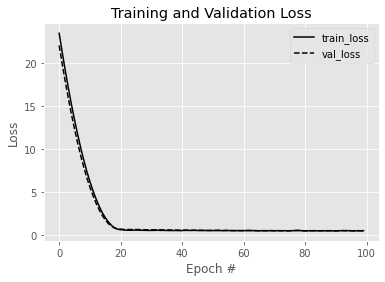

In [ ]:
# plot the training and validation loss

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(np.arange(0, 100), hist.history["loss"], label="train_loss", color='black' )
plt.plot(np.arange(0, 100), hist.history["val_loss"], label="val_loss", color='black', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plot.ylabel

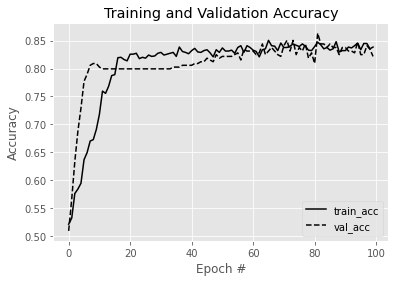

In [ ]:
# plot the training and validation accuracy

plt.style.use('ggplot')
plt.plot(np.arange(0, 100), hist.history["accuracy"], label="train_acc", color='black')
plt.plot(np.arange(0, 100), hist.history["val_accuracy"], label="val_acc", color='black', linestyle='--')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Alright, we see that we have addressed the over-fitting issue.

So do experiment with the hyper-parameters or changing the model architecture to see if you can increase the accuracy of the model, while keeping a check on over-fitting as well.